### **Introduction**

In this personal project, I aim to develop a deep learning model capable of classifying different types of heartbeats based on ECG signals. The implementation choices, including model selection, denoising techniques, and preprocessing strategies, will be thoroughly justified throughout this Jupyter Notebook.

To provide a structured approach, I have divided the project into distinct phases, each corresponding to a dedicated chapter. This workflow is inspired by the guidelines presented in [_Yaqoob Ansari et al._](https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2023.1246746/full), particularly Chapter 7, where the authors outline a methodology suitable for researchers new to ECG classification.

The project follows the following structured workflow:
1. **Database Selection Stage**: in this section, I discuss the dataset chosen for the project, outlining its characteristics and relevance to the task.
2. **Preprocessing Stage**: this section addresses the types of noise commonly found in ECG signals and presents the techniques employed to enhance the quality of the input data.
3. **Segmentation Stage**: here, I explore methods for partitioning ECG signals into smaller, meaningful segments to facilitate the learning process of the model.
4. **Feature Extraction Stage**: I assess whether additional features can be derived from the ECG data or whether the raw segmented signals provide sufficient information for classification.
5. **Classification Stage**: This section details the design and implementation of a deep learning model aimed at solving the heartbeat classification task.
6. **Evaluation Stage**: I analyze the model’s performance using standard evaluation metrics, providing insights into its effectiveness and limitations.
7. **Conclusions**: finally, I summarize the key takeaways from this project, discussing the main challenges encountered and the strategies adopted to overcome them. Additionally, I reflect on the model's limitations and propose potential improvements for future research.

This structured approach ensures clarity and coherence throughout the project, facilitating both implementation and interpretability.

### **Database selection stage**

For this project, I will use the MIT-BIH Arrhythmia Database, a collection of 30-minute ECG recordings from 47 patients, collected between 1975 and 1979. The dataset includes recordings from both healthy individuals and patients with heart conditions; however, it is slightly imbalanced, with a predominance of patients exhibiting cardiac abnormalities.


The first step is download the dataset from the [official website.](https://www.physionet.org/content/mitdb/1.0.0/)

The dataset documentation can be found [here.](https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm)


To correctly read and process the data, I will use the [WFDB (Waveform Database) library,](https://wfdb.io/) a widely used tool for handling physiological signal datasets.

In [1]:
import os
try:
    import wfdb
except ImportError:
    os.system("pip install wfdb")
    import wfdb

In [2]:
try:
  import torchmetrics
  from torchmetrics import Accuracy
except ImportError:
  os.system("pip install torchmetrics")
  import torchmetrics
  from torchmetrics import Accuracy

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import random
from tqdm import tqdm # Progress bar
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from torch.utils.data import random_split
from torch.optim.lr_scheduler import LinearLR

print(f"PyTorch version: {torch.__version__}")
print(f"wfdb version: {wfdb.__version__}")

PyTorch version: 2.6.0+cpu
wfdb version: 4.2.0


In [5]:
# Global variable to run code on colab or locally
COLAB = False

In [6]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')

#### **Let's visualise!**

I will use the [`plot_wfdb` method](https://wfdb.readthedocs.io/en/latest/plot.html) to visualize the ECG recording of patient #100.

For a clearer visualization, I will focus on the first 1000 samples of the ECG signal. 

Since the MIT-BIH Arrhythmia Database has a sampling frequency of 360 Hz, this subset corresponds to approximately 2.78 seconds of the patient's ECG recording.

The duration in seconds is given by:
$$\text{seconds} = \frac{\text{number of samples}}{\text{sampling frequency}} = \frac{1000}{360} \approx 2.78 \text{ seconds}$$

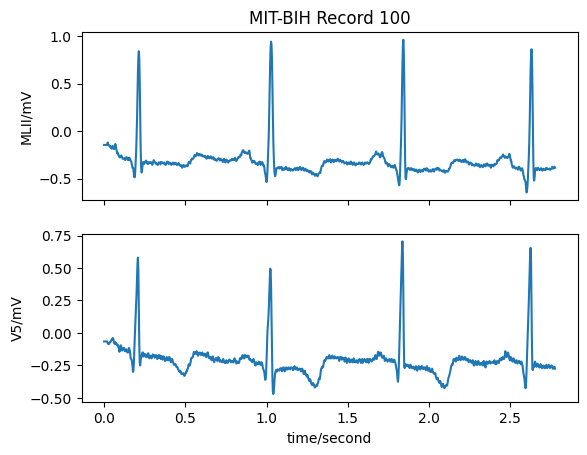

In [9]:
if COLAB:
  patient_path = "/content/gdrive/MyDrive/mit-bih-arrhythmia-database-1.0.0/100"
else:
  patient_path = "mit-bih-arrhythmia-database-1.0.0/100"
patient_record = wfdb.rdrecord(patient_path, sampto=1000)
wfdb.plot_wfdb(patient_record, title='MIT-BIH Record 100', time_units='seconds') # Plots the ECG

The first four heartbeats of patient #100 can be clearly observed.

A single ECG beat is divided according to the following labels:
* **P Label:** refers to the P wave, the first wave generated in the heartbeat cycle. It corresponds to the depolarization of the atria.
* **Q Label:** refers to the Q wave, the initial downward deflection following the P wave. It represents the initial depolarization of the interventricular septum.
* **R Label:** refers to the R wave, the largest upward deflection in the ECG cycle, corresponding to the depolarization of the main mass of the ventricles.
* **S Label:** refers to the S wave, the downward deflection following the R wave, representing the final phase of ventricular depolarization.
* **T Label:** refers to the T wave, which represents the repolarization (or recovery) of the ventricles.

Below is the diagram of an ECG beat with its labels including intervals and segments.
![title](img/electrocardiogram_diagram.png)

For more information, see the [Wikipedia page on Electrocardiography](https://en.wikipedia.org/wiki/Electrocardiography).

Returning to the WFDB library, using `__dict__` returns a dictionary containing all the ECG data. This dictionary provides a wealth of information:
* The first section contains metadata, including:
    * The patient number (`record_name`)
    * The number of leads recorded (`n_sig`)
    * Additional details about the patient
* The middle section stores the ECG data, specifically the voltages of the leads. In this case, there are two leads:
    * MLII (Modified Lead II)
    * V5 (Precordial Lead V5)
  
  These are two different types of ECG signals obtained from distinct lead configurations.
    * More info about leads [here](https://www.washingtonhra.com/ekg-monitoring/12-lead-electrocardiogram-ekg.php)
* The last section provides details about voltage values, units, data format, and other technical specifications.

In [10]:
print(patient_record.__dict__)

{'record_name': '100', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'], 'sig_name': ['MLII', 'V5'], 'p_signal': array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.385, -0.26 ],
       [-0.375, -0.26 ],
       [-0.385, -0.275]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['100.dat', '100.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [995, 1011], 'checksum': [44119, 64923], 'block_size': [0, 0]}


This data can also be accessed via dot notation:

In [11]:
print(f"Patient number: {patient_record.record_name}")
print(f"Leads: {patient_record.sig_name}")
print(f"ECG data: {patient_record.p_signal}")

Patient number: 100
Leads: ['MLII', 'V5']
ECG data: [[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.385 -0.26 ]
 [-0.375 -0.26 ]
 [-0.385 -0.275]]


In [ ]:
print(f"First 50 values of the first lead for patient 100: \n {patient_record.p_signal[:50, 0]}\n")
print(f"patient_record.p_signal's type: {type(patient_record.p_signal)} \npatient_record.p_signal's length: {len(patient_record.p_signal)}")

First 50 values of the first lead for patient 100: 
 [-0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.12  -0.135
 -0.145 -0.15  -0.16  -0.155 -0.16  -0.175 -0.18  -0.185 -0.17  -0.155
 -0.175 -0.18  -0.19  -0.18  -0.155 -0.135 -0.155 -0.19  -0.205 -0.235
 -0.225 -0.245 -0.25  -0.26  -0.275 -0.275 -0.275 -0.265 -0.255 -0.265
 -0.275 -0.29  -0.29  -0.29  -0.29  -0.285 -0.295 -0.305 -0.285 -0.275]

patient_record.p_signal's type: <class 'numpy.ndarray'> 
patient_record.p_signal's length: 1000


Most, but not all, of the patients' heartbeats have been labeled by medical experts. These labels, which will be referred to as annotations, are stored in the .atr file:

In [ ]:
if COLAB:
  drive.mount('/content/gdrive')
  annotations = wfdb.rdann('/content/gdrive/MyDrive/mit-bih-arrhythmia-database-1.0.0/100', 'atr')  # path to the .atr file
else:
  annotations = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/100', 'atr')  # path to the .atr file

print("First 20 annotations (or symbols) for Record 100:\n", annotations.symbol[: 20])

First 20 annotations (or symbols) for Record 100:
 ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


The term **annotations** is more appropriate than **labels** because these files contain not only heartbeat classifications but also medical comments, observations, and additional clinically relevant information about the beat.

Therefore, some preprocessing will be required to extract only the annotations relevant to the classification task.

### **Preprocessing stage**

Data preprocessing is a critical phase in arrhythmia detection. It involves cleaning and organasing the ECG data to make it suitable for machine learning/deep learning models.

I will split the preprocessing in 3 main steps:
* **Filtering**: ECG signals are susceptible to noise from various sources, including power line interference, muscle artifacts, and baseline wander. To enhance the signal quality, it is necessary applied filters. Typically these types of noises are located in the low frequency band of the frequency spectrum.


In [11]:
def high_pass_filter(original_signal, cutoff_frequency=0.5, sampling_rate=360, order=3):
  nyquist = 0.5 * sampling_rate
  normal_cutoff = cutoff_frequency / nyquist
  b, a = sp.signal.butter(order, normal_cutoff, btype='highpass', analog=False)
  filtered_signal = sp.signal.filtfilt(b, a, original_signal)
  return filtered_signal

1.1819206473890699e-06


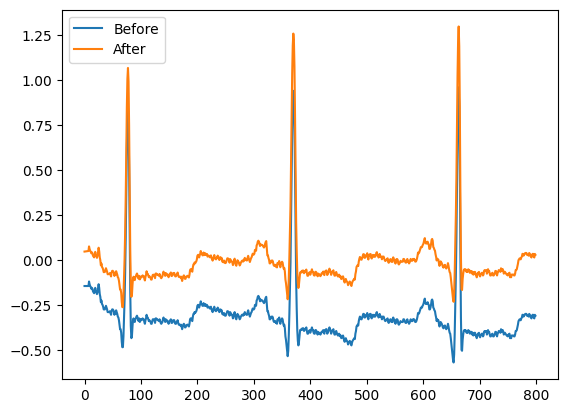

In [12]:
# Removing baseline wandering
filteredHighPassSignal = high_pass_filter(patient_record.p_signal[:,0])
print(filteredHighPassSignal.mean())
plt.plot(patient_record.p_signal[:,0][:800])
plt.plot(filteredHighPassSignal[:800])
plt.legend(("Before", "After"))
plt.show()

Another source of noise would be the power line interference. It occurs at 50-60Hz and is caused by fluctuations in the electrical grid.

Since I don't know if this type of noise is present in this dataset I can do a spectral analysis. To do this:
- I will apply the Fourier Transform (FFT): this transform allows you to go from the time domain (where we see the signal as it varies over time) to the frequency domain (where we see the frequency components of the signal).
- I will observe the peaks: if there are peaks at 50 Hz or 60 Hz, it is likely that there is interference from power lines and I will proceed with the removal.

In [13]:
def get_frequency_spectrum(signal):
  sampling_rate = 360  # Sampling rate in Hz

  # Calculate FFT of the signal
  fft_data = np.fft.fft(signal)  # Select the first lead
  frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)

  # Find the indices corresponding to the positive frequencies
  positive_frequencies = frequencies[:len(frequencies)//2]
  positive_fft_data = np.abs(fft_data[:len(fft_data)//2])

  # Filter for frequencies between 0 and 70 Hz
  freq_range = (positive_frequencies >= 0) & (positive_frequencies <= 70)
  filtered_frequencies = positive_frequencies[freq_range] # from 0Hz to 70Hz
  filtered_fft_data = positive_fft_data[freq_range]
  return filtered_frequencies, filtered_fft_data

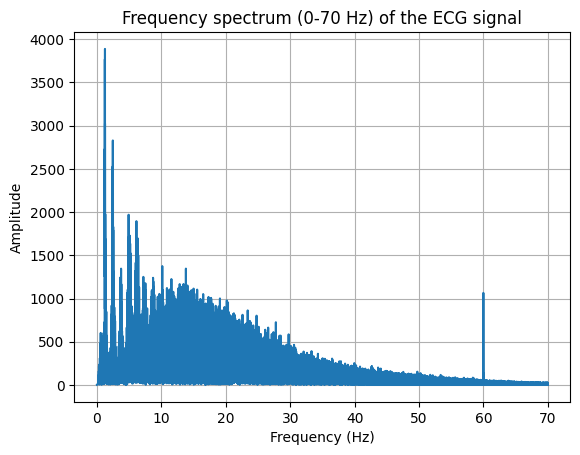

In [14]:
filtered_frequencies, filtered_fft_data = get_frequency_spectrum(filteredHighPassSignal)

# Displays the frequency spectrum between 0 and 70 Hz
plt.plot(filtered_frequencies, filtered_fft_data)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [15]:
def notchFilter(signal, notch_frequency=60, quality_factor=30, sampling_rate=360):
  # Calculate the notch filter coefficients
  b, a = sp.signal.iirnotch(notch_frequency / (sampling_rate / 2), quality_factor)

  # Filters the signal to remove 60Hz interference
  return sp.signal.filtfilt(b, a, signal)

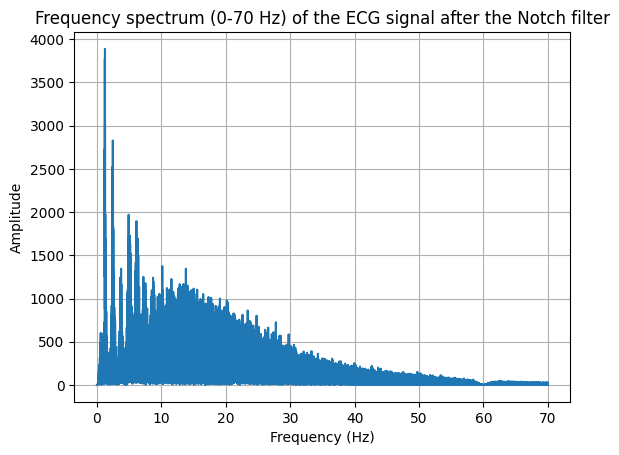

In [16]:
filtered_data_notch = notchFilter(filteredHighPassSignal)

filtered_frequencies, filtered_fft_data = get_frequency_spectrum(filtered_data_notch)

# Displays the frequency spectrum between 0 and 70 Hz
plt.plot(filtered_frequencies, filtered_fft_data)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal after the Notch filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

As we can see the frequency range after applying the Notch filter no longer has frequencies around 60Hz.


As we can see the frequency range after applying the Notch filter no longer has frequencies around 60hz.
Now let's plot the signals before and after applying the Notch filter.

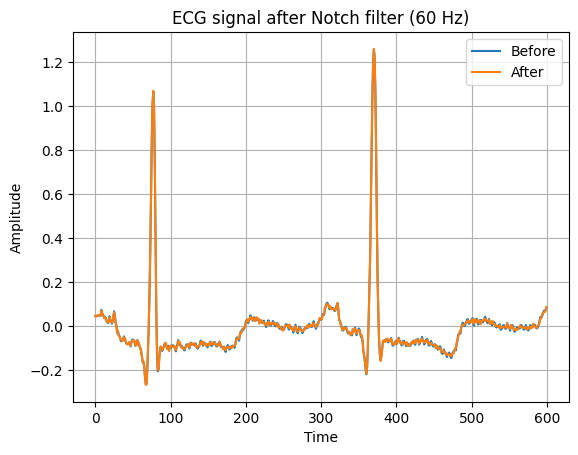

In [17]:
# Plot the new signal
plt.plot(filteredHighPassSignal[:600])
plt.plot(filtered_data_notch[:600])
plt.title("ECG signal after Notch filter (60 Hz)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()

As we can see the new filtered signal is much smoother than the pre-notch filter.

Finally, I will use a low-pass filter in order to cut the high frequencies. Usually an frequency's ECG signal is between 0.5-150 Hz, so I will cut all the frequency above 150 Hz.

In [18]:
def low_pass_filter(data, cutoff_freq=150, sampling_rate=360, order=3):
  nyquist = 0.5 * sampling_rate
  normal_cutoff = cutoff_freq / nyquist
  b, a = sp.signal.butter(order, normal_cutoff, btype='low', analog=False)
  filtered_data = sp.signal.filtfilt(b, a, data)
  return filtered_data

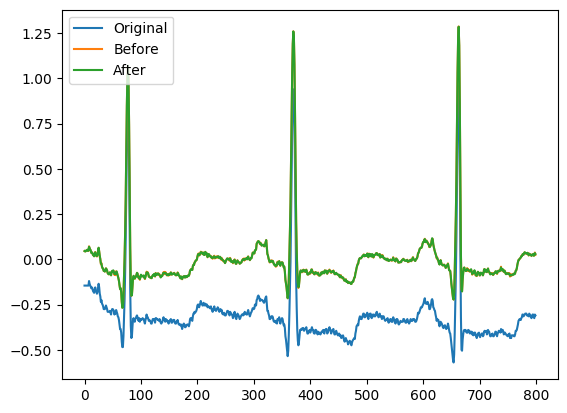

In [19]:
# Removing high frequencies > 150
filteredSignalFinal = low_pass_filter(filtered_data_notch)
plt.plot(patient_record.p_signal[:,0][:800])
plt.plot(filtered_data_notch[:800])
plt.plot(filteredSignalFinal[:800])
plt.legend(("Original", "Before", "After"))
plt.show()


* **Segmentation**: write a small introduction for the next stage

### **Segmentation stage**

Segmentation is the last part of the preprocessing which is extremely related to the way the database is structured and the choice of the deep learning model (which will be an LSTM model).
The MIT-BIH database offers labels for each heartbeat of the patient. The goal will be to segment the patients' ECG signals in such a way that each segment contains only one heartbeat, and assign it the associated label in the database.

The model will then predict, based on the segment, the type of arrhythmia of the heartbeat (segment).

To obtain segments each containing a single beat, a valid approach would be to identify the R peaks and then isolate the right and left sides of the R peak based on a normalized distance.

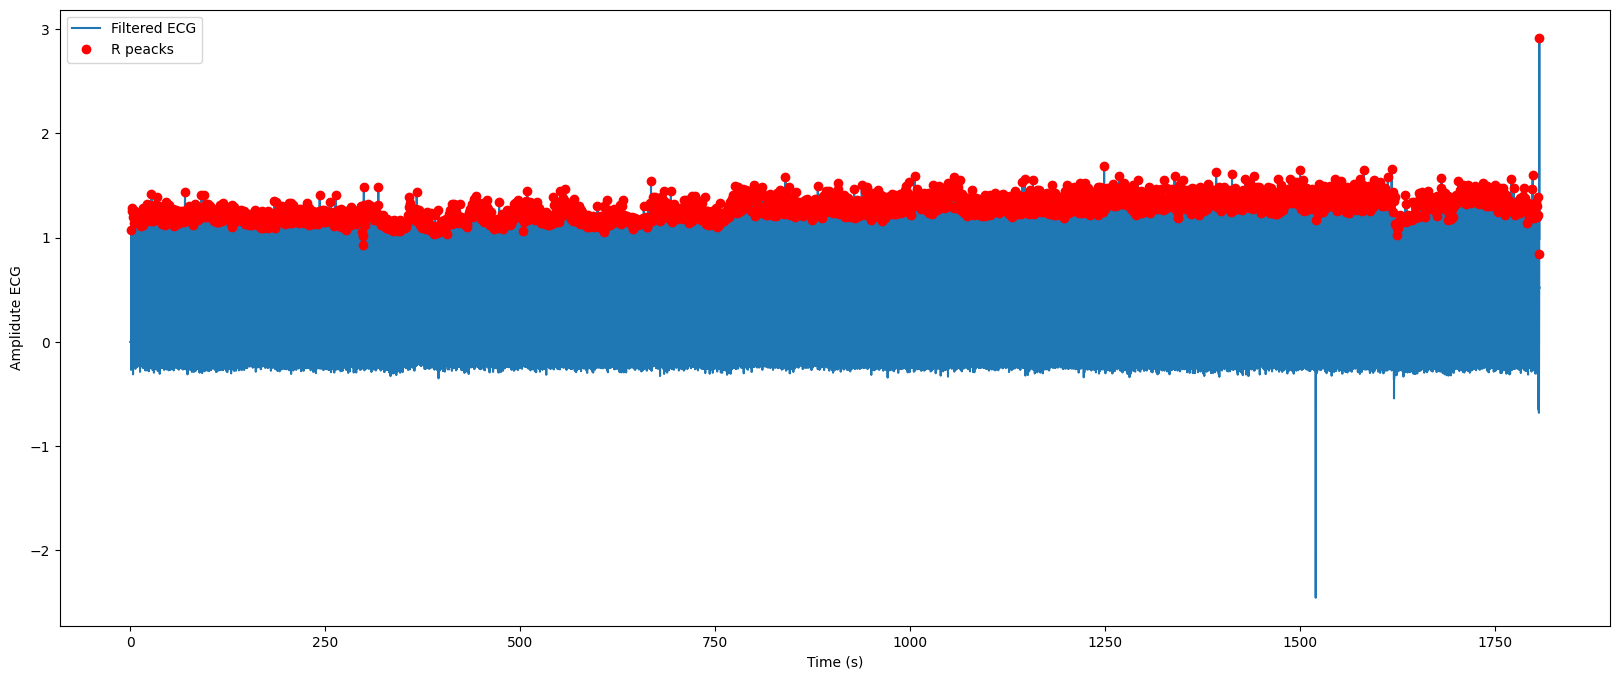

In [20]:
fs = 360  # Sampling rate (e.g. MIT-BIH)

# Add 1 second of padding both left and right
padding_length = fs  # Add 1 seconds of zeros
filteredSignalFinal_padded = np.concatenate((np.zeros(padding_length), filteredSignalFinal))  #, np.zeros(padding_length) Padding left and right

# Identifying peaks
peaks, _ = sp.signal.find_peaks(filteredSignalFinal_padded, height=0.5, distance=fs//4)  # Minimum height and distance between peaks
#signals, info = nk.ecg_process(filteredSignalFinal, sampling_rate=360, method="engzeemod2012")
#peaks = info['ECG_R_Peaks']

# Creating the time axis
t = np.arange(len(filteredSignalFinal_padded)) / fs  # Time in seconds

# Plot
plt.figure(figsize=(20, 8))
plt.plot(t, filteredSignalFinal_padded, label="Filtered ECG")  # X-axis: time
plt.plot(t[peaks], filteredSignalFinal_padded[peaks], "ro", label="R peacks")  # Use t[peaks] to align the x's
plt.xlabel("Time (s)")
plt.ylabel("Amplidute ECG")
plt.legend()
plt.show()

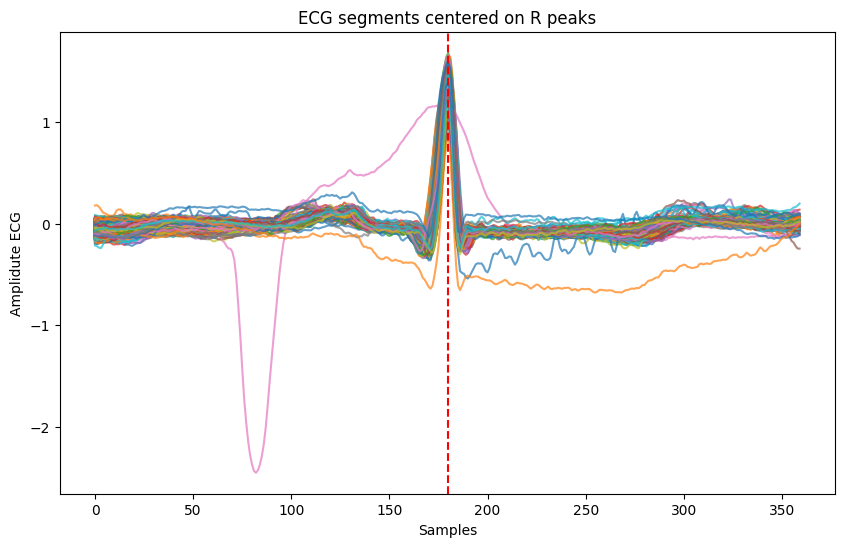

In [21]:
# define the length of the window around R
left = 180   # Samples on the left
right = 180  # Samples on the right

segments = []
for r in peaks:
  if r - left >= 0 and r + right < len(filteredSignalFinal_padded):  # Avoid edge problems
    segment = filteredSignalFinal_padded[r - left : r + right]
    segments.append(segment)

# Convert to array for easier plotting
segments = np.array(segments)

plt.figure(figsize=(10, 6))
for i, segment in enumerate(segments):
  plt.plot(segment, alpha=0.7, label=f"Beat # {i+1}")

plt.axvline(left, color='r', linestyle='--', label="Centered R peak")  # Vertical line for R peak
plt.xlabel("Samples")
plt.ylabel("Amplidute ECG")
plt.title("ECG segments centered on R peaks")
#plt.legend()
plt.show()

In [22]:
len(segments), len(valid_symbols)

(2272, 2273)

Something is wrong, the number of segments manually extracted are not equal to the number of segments annotated by the dataset.
Furthermore, there are several annotations that do not classify the type of beat (for example "+", "~" or "/") and therefore should not be taken into account.

We need to change strategy.

I will take the selected segments from the MIT-BIH dataset discarding all the labels that do not label the beat. In this way I will lose some signals to give as input to the model but at least the labels will be associated correctly and the segments will certainly be significant for the prediction of the beat type.

In [23]:
valid_beat_symbols = {"N", "L", "R", "A", "a", "J", "S", "V", "F","!", "e", "j", "E", "f", "x", "Q"}
valid_indices = [i for i, s in enumerate(annotations.symbol) if s in valid_beat_symbols]
filtered_samples = annotations.sample[valid_indices]
filtered_symbols = np.array(annotations.symbol)[valid_indices]

window_size = 200  # 100 on left, 100 on right
segments = []
labels = []

for r_peak, label in zip(filtered_samples, filtered_symbols):
  start = max(0, r_peak - window_size // 2)
  end = min(len(filteredSignalFinal), r_peak + window_size // 2)
  segment = filteredSignalFinal[start:end]

  # If the segment does not have the correct length, we discard it
  if len(segment) == window_size:
    segments.append(segment)
    labels.append(label)

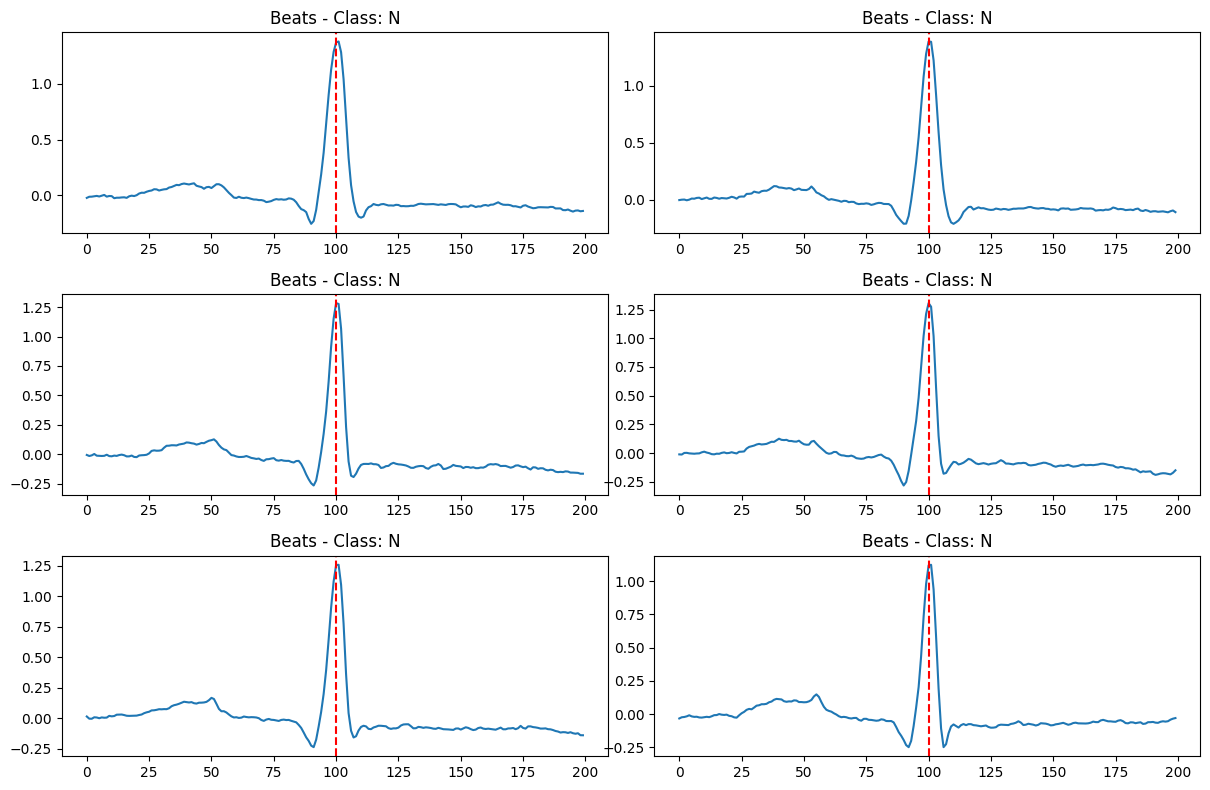

In [24]:
# We randomly choose some segments to plot
num_plots = 6
random_indices = random.sample(range(len(segments)), num_plots)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices, 1):
  plt.subplot(3, 2, i)
  plt.plot(segments[idx])
  plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Indicates the center (peak R)
  plt.title(f"Beats - Class: {labels[idx]}")
plt.tight_layout()
plt.show()

Generally the annotations made by doctors in the MIT-BIH dataset are placed around the R peak or around the QRS complex.

So if I plot all the segments I expect to get the R peak in the center.

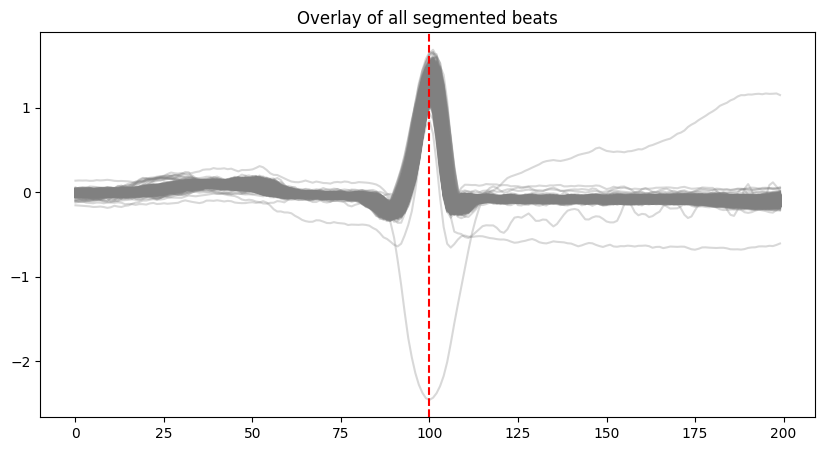

In [25]:
plt.figure(figsize=(10, 5))
for segment in segments:
  plt.plot(segment, color="gray", alpha=0.3)  # Transparency for overlay
plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Center
plt.title("Overlay of all segmented beats")
plt.show()

As I expected the plot is as I described above. Having the R peak centered around the 100 segment could help the model identify if the beat is suffering from arrhythmia or not.

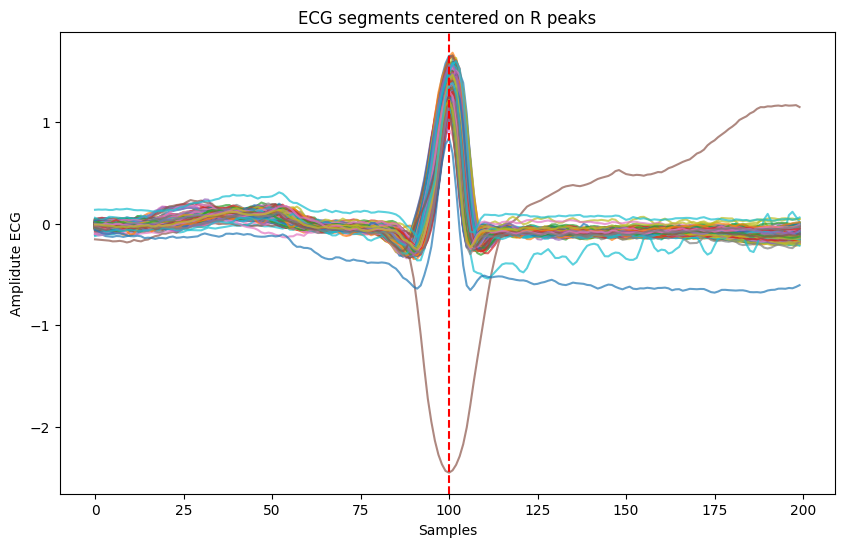

In [26]:
plt.figure(figsize=(10, 6))
for i, segment in enumerate(segments):
  plt.plot(segment, alpha=0.7, label=f"Beat # {i+1}")

plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Center
plt.xlabel("Samples")
plt.ylabel("Amplidute ECG")
plt.title("ECG segments centered on R peaks")
#plt.legend()
plt.show()

In [27]:
len(segments)

2271

This path is more promising. Even though the segments are much fewer than the previous length, at least we are sure that they are clinically relevant segments for our purposes.

Now let's preprocess all the signals available.

For convenience I will focus only on the first lead.

In [28]:
def filterBeatAnnotations(annotations, valid_beat_symbols):
  # Filter annotations to keep only valid beats
  valid_indices = [i for i, s in enumerate(annotations.symbol) if s in valid_beat_symbols]
  filtered_samples = annotations.sample[valid_indices]  # Beat positions
  filtered_symbols = np.array(annotations.symbol)[valid_indices]  # Beat labels
  return filtered_symbols, filtered_samples
  #print(f"Number of beats found: {len(filtered_symbols)}")

In [29]:
def signalFiltering(raw_signal):
  # High-pass filter
  filteredHighPassSignal = high_pass_filter(raw_signal)
  # Notch filter
  filteredNotchSignal = notchFilter(filteredHighPassSignal)
  # Low-pass filter
  return low_pass_filter(filteredNotchSignal)

In [30]:
def simplifyLabel(label):
  match label:
      case "N" | "L" | "R" | "j" | "e":
          return "N"
      case "A" | "a" | "S" | "J":
          return "S"
      case "V" | "E":
          return "V"
      case "F":
          return "F"
      case _:
          return "U"

def segmentationProcess(signal, filtered_samples, filtered_symbols):
  window_size = 200  # 100 on left, 100 on right
  segments = []
  labels = []

  for r_peak, raw_label in zip(filtered_samples, filtered_symbols):
    label = simplifyLabel(raw_label)
    start = max(0, r_peak - window_size // 2)
    end = min(len(signal), r_peak + window_size // 2)
    segment = signal[start:end]

    # If the segment does not have the correct length, we discard it
    if len(segment) == window_size:
      segments.append(segment)
      labels.append(label)

  return segments, labels # There are list!

In [31]:
def normalizationProcess(raw_segments, scaler):
  normalized_beats = []
  for raw_segment in raw_segments:
    normalized_segment = scaler.fit_transform(np.array(raw_segment).reshape(-1, 1)).reshape(-1)
    normalized_beats.append(normalized_segment)

  return normalized_beats

I proceed to collect all the data available in the dataset. For each patient I retrieve the information: the two raw ECG leads and the filtered segment labels with only the annotations regarding the type of heartbeat.

The ECG signals are then filtered, segmented with a fixed size and normalized between (0, 1) since later in the model I will use the softmax activation function and for reasons of numerical stability it is better to remain in the softmax image.

Subsequently we output a list of dictionaries where each dictionary represents a patient.

In [34]:
if COLAB:
  drive.mount('/content/gdrive')
  path = "/content/gdrive/MyDrive/mit-bih-arrhythmia-database-1.0.0"
else:
  path = "/mit-bih-arrhythmia-database-1.0.0"

valid_beat_symbols = {"N", "L", "R", "A", "a", "J", "S", "V", "F","!", "e", "j", "E", "f", "x", "Q"}
patients_data = []
scaler = MinMaxScaler(feature_range=(0, 1))

print(f"Start loading...")
for patient_id in tqdm(range(100, 235), initial=1, total=135):  # From patient 100 to patient 234
  try:
    patient_record = wfdb.rdrecord(f"{path}/{patient_id}")
    annotations = wfdb.rdann(f"{path}/{patient_id}", 'atr')

    filtered_symbols, filtered_samples = filterBeatAnnotations(annotations, valid_beat_symbols)
    first_lead_cleaned_signal = signalFiltering(patient_record.p_signal[:, 0]) # First lead (numpy array)
    second_lead_cleaned_signal = signalFiltering(patient_record.p_signal[:, 1]) # Second lead (numpy array)

    first_lead_raw_segments, first_lead_labels = segmentationProcess(first_lead_cleaned_signal, filtered_samples, filtered_symbols)
    second_lead_raw_segments, second_lead_labels = segmentationProcess(second_lead_cleaned_signal, filtered_samples, filtered_symbols)
    first_lead_segments = normalizationProcess(first_lead_raw_segments, scaler)
    second_lead_segments = normalizationProcess(second_lead_raw_segments, scaler)

    segments = first_lead_segments + second_lead_segments
    labels = first_lead_labels + second_lead_labels

    # Save everything in a dictionary
    patient_entry = {
      "patient_id": patient_id,
      "ecg_first_lead": first_lead_cleaned_signal,
      "ecg_second_lead": second_lead_cleaned_signal,
      "fs": patient_record.fs,
      "lead_names": patient_record.sig_name,
      "beats": segments,
      "beat_labels": labels,
    }
    patients_data.append(patient_entry)

  except FileNotFoundError: # Catch error if the patient's number does not exist
    #print(f"Patient {patient_id} not found, moving next...")
    pass

print(f"Loaded compleated!")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Start loading...


136it [01:47,  1.26it/s]

Loaded compleated!


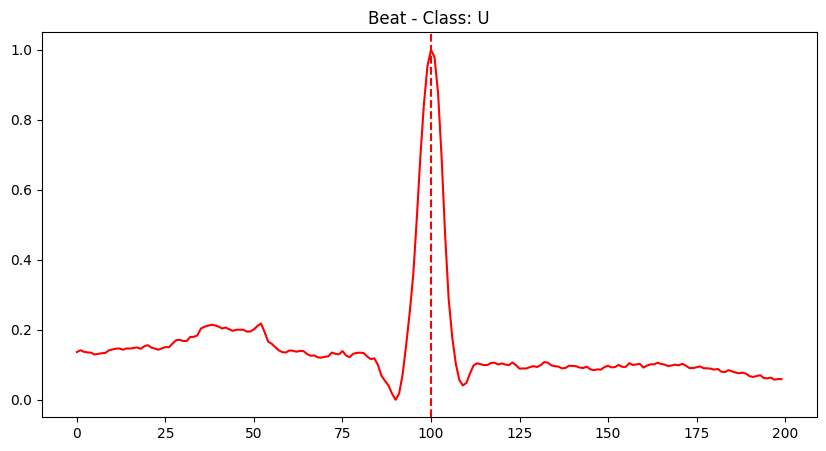

In [35]:
plt.figure(figsize=(10, 5))
segment = patients_data[0].get('beats')[0]
plt.plot(segment, color="r")  # Transparency for overlay
plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Center
plt.title(f"Beat - Class: {patients_data[4].get('beat_labels')[0]}")
plt.show()

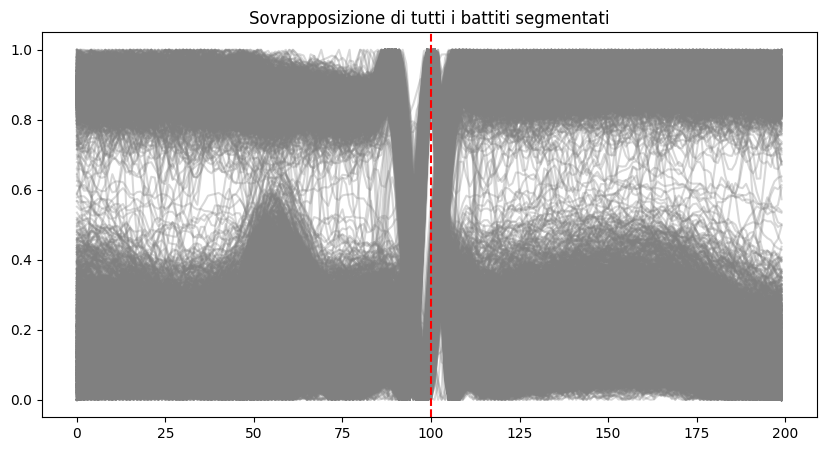

In [36]:
plt.figure(figsize=(10, 5))
for segment in patients_data[40].get('beats'):
  plt.plot(segment, color="gray", alpha=0.3)  # Transparency for overlay
plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Center
plt.title("Sovrapposizione di tutti i battiti segmentati")
plt.show()

all_segments_values' shape: (41240400,)
Media: 0.4411, Deviazione Std: 0.3085
Min: 0.0000, Max: 1.0000


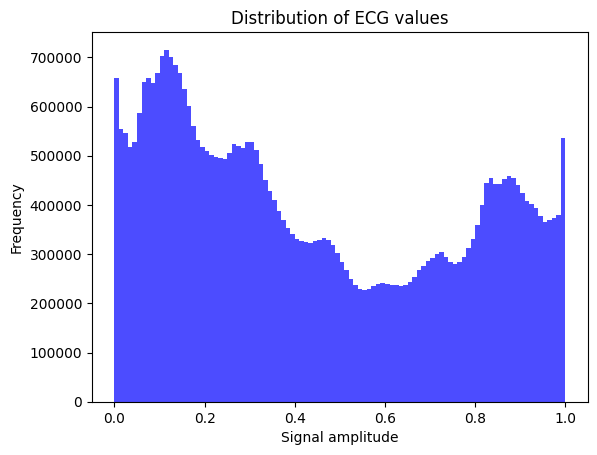

In [37]:
# Initialize the list to collect all segments
all_segments = []
all_labels = []

for patient in patients_data:
  for segment, label in zip(patient.get('beats'), patient.get('beat_labels')):
    # Add the segment as numpy array
    all_segments.append(np.array(segment))
    all_labels.append(np.array(label))

# Lengths equal between segments and labels, do not worry!
all_segments_values = np.concatenate(all_segments)
all_labels = np.array(all_labels)

# Check all_segment_values' final shape
print("all_segments_values' shape:", all_segments_values.shape)

# Get mean, standard deviation, min and max
mean_val = np.mean(all_segments_values)
std_val = np.std(all_segments_values)
min_val, max_val = np.min(all_segments_values), np.max(all_segments_values)
print(f"Media: {mean_val:.4f}, Deviazione Std: {std_val:.4f}")
print(f"Min: {min_val:.4f}, Max: {max_val:.4f}")

# Distribution histogram
plt.hist(all_segments_values, bins=100, alpha=0.7, color="blue")
plt.title("Distribution of ECG values")
plt.xlabel("Signal amplitude")
plt.ylabel("Frequency")
plt.show()

In [38]:
# Function to apply time shift
def time_shift(signal, shift=5):
  output = np.roll(signal, shift)
  return output

# Function to change the amplitude
def amplitude_scaling(signal, scale_range=(0.9, 1.1)):
  scale = np.random.uniform(*scale_range)
  output = signal * scale
  return output

In [39]:
def rebalance_classes_N_and_F(all_segments, all_labels):
  ### Downsampling class N -> from 90603 to 8000 segments
  target_N = 20000
  # Find the indexes of class "N"
  indices_N = [i for i, label in enumerate(all_labels) if label == 'N']
  # Randomly select 8000 indexes from the available ones
  selected_N_indices = np.random.choice(indices_N, target_N, replace=False)
  # Find the indices of all other classes
  other_indices = [i for i, label in enumerate(all_labels) if label != 'N']
  # Combine the indexes while maintaining the balance in the new list
  final_indices = list(selected_N_indices) + other_indices
  # Reorder labels as in the original
  final_indices.sort()
  # Create new balanced lists
  balanced_segments = [all_segments[i] for i in final_indices]
  balanced_labels = [all_labels[i] for i in final_indices]

  ### Data augmentation class F -> from 802 to 1604
  ## Time Shift (401 new signals) + Amplitude Scaling (401 new signals)
  # Find the indexes of class "F"
  indices_F = [i for i, label in enumerate(balanced_labels) if label == 'F']
  # List for new segments and labels
  augmented_segments = []
  augmented_labels = []

  selected_indices = np.random.choice(indices_F, size=401, replace=False)  # Seleziona 401 indici casuali
  for i in selected_indices:
    shift_value = np.random.randint(-5, 6)  # Random shift between -5 e +5
    augmented_segment = np.array(time_shift(balanced_segments[i], shift=shift_value))
    augmented_segments.append(augmented_segment)
    augmented_labels.append('F')

  selected_indices = np.random.choice(indices_F, size=401, replace=False)  # Seleziona 401 indici casuali
  for i in selected_indices:
    scaler = MinMaxScaler(feature_range=(0, 1))
    augmented_segment = scaler.fit_transform(np.array(amplitude_scaling(balanced_segments[i])).reshape(-1, 1)).reshape(-1) # Normalized amplitude scaling (multiply the signal by a range (0.9, 1.1))
    augmented_segments.append(augmented_segment)
    augmented_labels.append('F')

  # Add the augmented data to the dataset
  balanced_segments.extend(augmented_segments)
  balanced_labels.extend(augmented_labels)

  return balanced_segments, balanced_labels


We can clearly observe that the dataset is highly unbalanced.
* The N type beats are about 90,000
* The F type beats are only about 800

This is unfortunate if we want to train a deep learning model as it might learn to classify N beats as the majority and discard the classification of one beat as F as statistically irrelevant. It is necessary to modify the dataset.
* First of all, we reduce the segments labeled as N to 8000 so that they are still the majority segments, as they are normal beats but still not too many so as not to force the convergence of the model around N
* While for the F segments I will apply two types of data augmentation:
    * I will create 401 new segments by randomly shifting 401 random signals by a random number between -5 and +5. This number is also randomly generated
    * I will create 401 signals by changing the amplitude of 401 randomly chosen signals by a factor between 0.9 and 1.1 randomly chosen

In [40]:
# Count the occurrences of each label
print(f"Length before downsampling on label N and data augmentation on label F:")
unique_labels, counts = np.unique(all_labels, return_counts=True)
tot = 0
# Print the results
for label, count in zip(unique_labels, counts):
  print(f"Label {label}: {count}")
  tot += count
print(f"Total count: {tot}\n")

print(f"Length after downsampling on label N and data augmentation on label F:")
new_all_segments, new_all_labels = rebalance_classes_N_and_F(all_segments, all_labels)
unique_labels, counts = np.unique(new_all_labels, return_counts=True)
tot = 0
# Print the results
for label, count in zip(unique_labels, counts):
  print(f"Label {label}: {count}")
  tot += count
print(f"Total count: {tot}")

Length before downsampling on label N and data augmentation on label F:
Label F: 1604
Label N: 181206
Label S: 5562
Label U: 3360
Label V: 14470
Total count: 206202

Length after downsampling on label N and data augmentation on label F:
Label F: 2406
Label N: 20000
Label S: 5562
Label U: 3360
Label V: 14470
Total count: 45798


With these operations we went from 103101 segments to 21300. Fewer segments but better balanced than before.

In [41]:
check = True
count_true = 0
count_false = 0
for segment in new_all_segments:
  if segment.ndim == 1:
    check = True
    count_true += 1
  else:
    print(f"dim: {segment.ndim}")
    check = False
    count_false += 1

print(f"The check is: {check}")
print(f"Count_true : {count_true}")
print(f"Count_false : {count_false}")

The check is: True
Count_true : 45798
Count_false : 0


In [42]:
print(f"Segments {type(new_all_segments)}, len: {len(new_all_segments)}")
print(f"Segment {type(new_all_segments[0])}, len: {len(new_all_segments[0])}")
print(f"Labels {type(new_all_labels)}, len: {len(new_all_labels)}")

Segments <class 'list'>, len: 45798
Segment <class 'numpy.ndarray'>, len: 200
Labels <class 'list'>, len: 45798


In [43]:
# Check the lengths of sublists or arrays
lengths = [len(segment) for segment in new_all_segments]
print(f"Lengths of segments: {lengths}")

Lengths of segments: [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200

In [44]:
numpy_segments = np.array(new_all_segments)
print(f"numpy_segments' shape: {numpy_segments.shape}")
numpy_segments = np.expand_dims(numpy_segments, axis=-1) # (batch_size, segment's values, label)
print(f"new numpy_segments' shape: {numpy_segments.shape}")

numpy_labels = np.array(new_all_labels)
print(f"all_labels' shape: {numpy_labels.shape}")

numpy_segments' shape: (45798, 200)
new numpy_segments' shape: (45798, 200, 1)
all_labels' shape: (45798,)


The `torch.utils.data` module provides classes to load and manipulate datasets. The `Dataset` class is the base class for all datasets. We can define our own dataset by subclassing `Dataset` and defining the `__len__` and `__getitem__` methods. The `__len__` method should return the size of the dataset and the `__getitem__` method should return the $i$-th sample of the dataset.

The `DataLoader` class is used to load the dataset and provide batches of samples. It takes as input a dataset and the batch size.

In [45]:
class ECGDataset(Dataset):
  def __init__(self, X, y): # transform=None (take into account later)
    assert len(X) == len(y), "X e y devono avere la stessa lunghezza"
    assert len(X) > 0, "X non può essere vuoto"
    assert len(y) > 0, "y non può essere vuoto"
    """
    X: NumPy array of shape (n_samples, n_timesteps, n_features)
    y: NumPy array of shape (n_samples,)
    transform: Transformation function to apply to data
    """
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)
    #self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    segment = self.X[idx]
    label = self.y[idx]

    """if self.transform:
        segment = self.transform(segment)"""

    return segment, label

In [46]:
# Convert string labels to numerical indices
label_encoder = LabelEncoder()
all_labels_numeric = label_encoder.fit_transform(numpy_labels)

"""# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels_numeric), y=all_labels_numeric)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Create a WeightedRandomSampler to balance the dataset
sample_weights = class_weights_tensor[all_labels_numeric]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)"""

# Create the dataset and the DataLoader
dataset = ECGDataset(numpy_segments, all_labels_numeric)
batch_size = 128
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create a sampler only for the training set
train_labels = [train_dataset.dataset.y[i] for i in train_dataset.indices]
train_labels = torch.tensor(train_labels, dtype=torch.long)
class_counts = torch.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Create a DataLoader for validation (without sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### **Feature extraction stage**

For the model that I want to implement later, I want to pass the ECG signals directly to the model, therefore the amplitude values ​​over time.

This type of learning is called end-to-end learning, given this implementation choice I will not delve into the various feature extraction techniques.

### **Classification stage**

Since we are dealing with time series data I decided to implement a simple LSTM, as it has better performance than a RNN, and if the results are satisfactory it is possible to try to implement a Transformers model.

I will implement a model with:
* 4 bidirectional LSTM layers with 128 hidden neurons in each layer
* A batch normalization between each layer.
* A final fully connected to perform a probabilistic classification
* A dropout between the last LSTM layer and the fully connected to avoid overfitting

In [47]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [48]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size1, num_classes, dropout_rate=0.1):
    super(LSTMModel, self).__init__()

    # LSTM Layer 1
    self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True, bidirectional=True)
    self.batch_norm1 = nn.BatchNorm1d(2*hidden_size1)

    # LSTM Layer 2
    self.lstm2 = nn.LSTM(2*hidden_size1, hidden_size1, batch_first=True, bidirectional=True)
    self.batch_norm2 = nn.BatchNorm1d(2*hidden_size1)

    # LSTM Layer 3
    self.lstm3 = nn.LSTM(2*hidden_size1, hidden_size1, batch_first=True, bidirectional=True)
    self.batch_norm3 = nn.BatchNorm1d(2*hidden_size1)

    # LSTM Layer 4
    self.lstm4 = nn.LSTM(2*hidden_size1, hidden_size1, batch_first=True, bidirectional=True)
    self.batch_norm4 = nn.BatchNorm1d(2*hidden_size1)

    # Fully Connected Layer
    self.dropout = nn.Dropout(dropout_rate)
    self.fc = nn.Linear(2*hidden_size1, num_classes)

  def forward(self, x):
    # LSTM Layer 1
    x, _ = self.lstm1(x)  # Output shape: (batch_size, 200, hidden_size1)
    x = self.batch_norm1(x.permute(0, 2, 1)).permute(0, 2, 1)

    # LSTM Layer 2
    x, _ = self.lstm2(x)  # Output shape: (batch_size, 200, hidden_size2)
    x = self.batch_norm2(x.permute(0, 2, 1)).permute(0, 2, 1)

    # LSTM Layer 3
    x, _ = self.lstm3(x)  # Output shape: (batch_size, 200, hidden_size2)
    x = self.batch_norm3(x.permute(0, 2, 1)).permute(0, 2, 1)

    # LSTM Layer 4
    x, _ = self.lstm4(x)  # Output shape: (batch_size, 200, hidden_size2)
    x = self.batch_norm4(x.permute(0, 2, 1))#.permute(0, 2, 1)

    # Take the final time step output
    x = x[..., -1]  # Output shape: (batch_size, hidden_size2)

    # Fully Connected Layer
    x = self.dropout(x)
    x = self.fc(x)  # Output shape: (batch_size, num_classes)

    return x

# Define model parameters
input_size = 1  # Number of features (1 for the lead of ECG)
hidden_size1 = 160  # Number of hidden units in LSTM Layer 1
num_classes = 5     # Number of classes (F, N, S, U, V)
dropout_rate = 0.1  # Dropout rate

# Initialize the model
model = LSTMModel(input_size, hidden_size1, num_classes, dropout_rate).to(device)

# Print the model architecture
print(model)

LSTMModel(
  (lstm1): LSTM(1, 160, batch_first=True, bidirectional=True)
  (batch_norm1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(320, 160, batch_first=True, bidirectional=True)
  (batch_norm2): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm3): LSTM(320, 160, batch_first=True, bidirectional=True)
  (batch_norm3): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm4): LSTM(320, 160, batch_first=True, bidirectional=True)
  (batch_norm4): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=320, out_features=5, bias=True)
)


As a loss I will use cross entropy which already implements the sigmoid activation function.

While as an optimizer I will use AdamW which represents the current state of the art with a simple linear scheduler, so that the learning rate is reduced as the training progresses.

In [49]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), weight_decay=0, lr=0.0001)
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 50
scheduler = LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=num_epochs)
#scheduler = lrs.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [50]:
"""import torch
import torch.optim.lr_scheduler as lrs
from torch.optim import SGD
import matplotlib.pyplot as plt

STEPS = 100

#optimizer = SGD([torch.tensor(1)], lr=0.05)
# Use a scheduler of your choice below.
# Great for debugging your own schedulers!
scheduler = lrs.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=STEPS)

lrs = []
for _ in range(100):
    optimizer.step()
    lrs.append(scheduler.get_lr())
    scheduler.step()

plt.plot(lrs)
plt.show()"""

'import torch\nimport torch.optim.lr_scheduler as lrs\nfrom torch.optim import SGD\nimport matplotlib.pyplot as plt\n\nSTEPS = 100\n\n#optimizer = SGD([torch.tensor(1)], lr=0.05)\n# Use a scheduler of your choice below.\n# Great for debugging your own schedulers!\nscheduler = lrs.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=STEPS)\n\nlrs = []\nfor _ in range(100):\n    optimizer.step()\n    lrs.append(scheduler.get_lr())\n    scheduler.step()\n\nplt.plot(lrs)\nplt.show()'

In [51]:
print(f"Train set size: {len(train_dataset)}")
print(f"Val set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Train loader batches: {len(train_loader)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Dataset length length: {len(train_loader.dataset)}")
print(f"Sampler length: {len(sampler)}")

Train set size: 32058
Val set size: 6869
Test set size: 6871
Train loader batches: 251
Train dataset size: 32058
Dataset length length: 32058
Sampler length: 32058


For the training loop I decided to set 50 epochs, and to implement patience as early stopping: if after 10 consecutive epochs the validation loss does not improve, the training stops, saving the model with the best validation loss.

In [52]:
# Define early stopping parameters
patience = 10  # Number of epochs to wait before stopping
best_val_loss = np.inf  # Initialize best validation loss to infinity
trigger_times = 0  # Counter for epochs without improvement

training_loss = []
validation_loss = []
accuracy_train = []
accuracy_val = []

torchmetric_accuracy = Accuracy(task="multiclass", num_classes=5).to(device)

# Training loop with early stopping
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  running_acc = 0.0
  for batch_segments, batch_labels in train_loader:
    # Move data to device
    batch_segments = batch_segments.to(device)
    batch_labels = batch_labels.to(device)

    # Forward pass
    outputs = model(batch_segments)
    loss = criterion(outputs, batch_labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    running_acc += torchmetric_accuracy(torch.softmax(outputs, dim=1).argmax(dim=1), batch_labels)

  scheduler.step()

  # Calculate training loss and training accuracy for the epoch
  train_loss = running_loss / len(train_loader)
  training_loss.append(train_loss)
  train_acc = running_acc.item() / len(train_loader)
  accuracy_train.append(train_acc)

  # Validation phase
  model.eval()
  val_loss = 0.0
  val_acc = 0.0
  with torch.no_grad():
    for batch_segments, batch_labels in val_loader:
      batch_segments = batch_segments.to(device)
      batch_labels = batch_labels.to(device)

      outputs = model(batch_segments)
      loss = criterion(outputs, batch_labels)
      val_loss += loss.item()
      val_acc += torchmetric_accuracy(torch.softmax(outputs, dim=1).argmax(dim=1), batch_labels)

  # Calculate validation loss for the epoch
  val_loss /= len(val_loader)
  validation_loss.append(val_loss)
  val_acc = val_acc.item() / len(val_loader)
  accuracy_val.append(val_acc)

  print(f"{'-'*100}")
  print(f"Epoch [{epoch+1}/{num_epochs}]: \n Train Loss: {train_loss:.4f}, Accuracy: {train_acc} | Val Loss: {val_loss:.4f}, accuracy: {val_acc}\n Learning rate: {optimizer.param_groups[0]['lr']}")

  # Start early stopping logic after a certain number of epochs
  if num_epochs > 10:
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      trigger_times = 0
      # Save the best model
      torch.save(model.state_dict(), 'best_model.pth')
      print("Validation loss improved. Model saved.")
    else:
      trigger_times += 1
      print(f"Validation loss did not improve. Trigger times: {trigger_times}/{patience}")

      # Stop training if patience is exceeded
      if trigger_times >= patience:
        print(f"Early stopping at epoch {epoch+1}!")
        break
  print(f"{'-'*100}")

print("Training complete!")

----------------------------------------------------------------------------------------------------
Epoch [1/50]: 
 Train Loss: 1.2920, Accuracy: 0.46858148460844123 | Val Loss: 1.4269, accuracy: 0.3331410090128581
 Learning rate: 9.82e-05
Validation loss improved. Model saved.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch [2/50]: 
 Train Loss: 1.0440, Accuracy: 0.6019746696806524 | Val Loss: 1.1208, accuracy: 0.5349724381058304
 Learning rate: 9.640000000000001e-05
Validation loss improved. Model saved.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch [3/50]: 
 Train Loss: 0.9557, Accuracy: 0.6405080362145169 | Val Loss: 1.0346, accuracy: 0.595601823594835
 Learning ra

### **Evaluation stage**

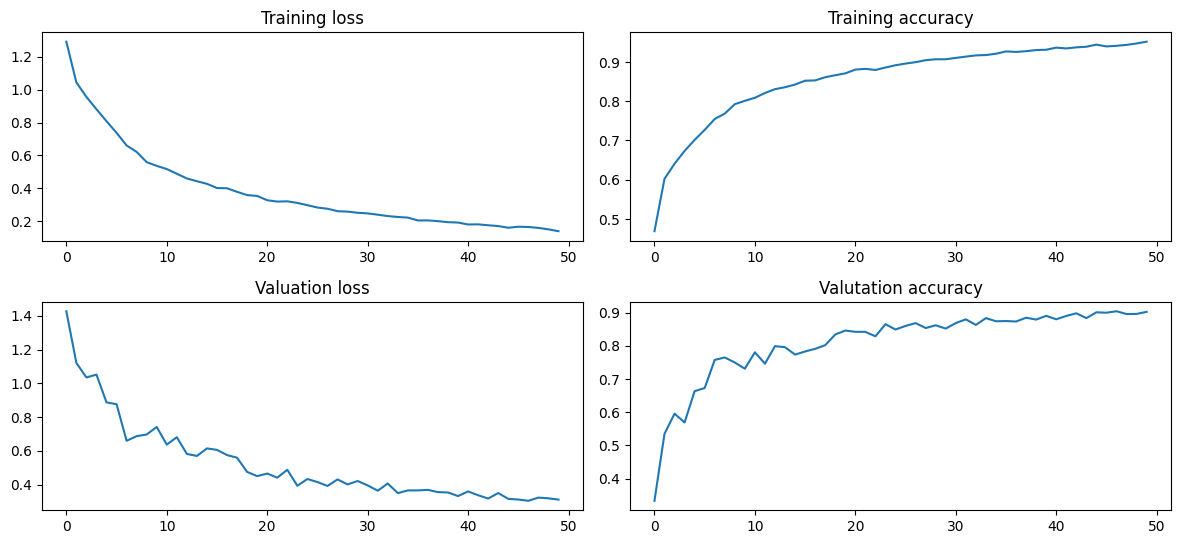

In [53]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
plt.plot(training_loss)
plt.title(f"Training loss")

plt.subplot(3, 2, 2)
plt.plot(accuracy_train)
plt.title(f"Training accuracy")

plt.subplot(3, 2, 3)
plt.plot(validation_loss)
plt.title(f"Valuation loss")

plt.subplot(3, 2, 4)
plt.plot(accuracy_val)
plt.title(f"Valutation accuracy")

plt.tight_layout()
plt.show()

In [54]:
model.eval()

# Test set predictions
all_preds = []
all_labels = []
probabilities = []  # List for saving probabilities

with torch.inference_mode():
  for batch_segments, batch_labels in test_loader:
    batch_segments = batch_segments.to(device)

    # Get logits from model
    outputs = model(batch_segments)

    # Apply softmax to get probabilities
    probs = torch.softmax(outputs, dim=1)  # Probability of each class
    probabilities.extend(probs.cpu().numpy())  # Add probabilities to the list

    # Get the above classes
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(batch_labels.numpy())

# Convert Lists to NumPy Arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
probabilities = np.array(probabilities)  # Array 2D: [num_samples, num_classes]

# 1. Classification Report (include Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# 3. AUC-ROC (requires probabilities for each class)
try:
  auc_macro = roc_auc_score(all_labels, probabilities, multi_class="ovo", average="macro")
  auc_weighted = roc_auc_score(all_labels, probabilities, multi_class="ovo", average="weighted")
  print(f"\nAUC-ROC (Macro): {auc_macro:.4f}")
  print(f"AUC-ROC (Weighted): {auc_weighted:.4f}")
except Exception as e:
  print(f"\nErrore nel calcolo dell'AUC: {e}")

# Convert predictions and labels to PyTorch tensors
all_preds_tensor = torch.tensor(all_preds).to(device)
all_labels_tensor = torch.tensor(all_labels).to(device)

# Calculate accuracy using torchmetrics
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=5).to(device)
accuracy = torchmetric_accuracy(all_preds_tensor, all_labels_tensor)
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

           F       0.76      0.92      0.83       344
           N       0.94      0.88      0.91      2997
           S       0.75      0.86      0.80       844
           U       0.89      0.93      0.91       491
           V       0.95      0.93      0.94      2195

    accuracy                           0.90      6871
   macro avg       0.86      0.91      0.88      6871
weighted avg       0.91      0.90      0.90      6871


Confusion Matrix:
[[ 315   14    4    2    9]
 [  41 2640  216   22   78]
 [   5   92  729    4   14]
 [   0   16    1  459   15]
 [  54   44   25   30 2042]]

AUC-ROC (Macro): 0.9871
AUC-ROC (Weighted): 0.9845
Accuracy: 0.9002


### **Conclusions**

#### **What did I learn?**

#### **Room for Improvement**